• Loaded dataset from: /content/loan_approval_dataset.csv
🚀 STARTING LOAN APPROVAL PREDICTION ANALYSIS
DATASET OVERVIEW
Dataset shape: (4269, 13)
Samples: 4269
• Dropped ID-like columns: ['loan_id', ' residential_assets_value']
• Target column inferred as: ' loan_status'

DATASET INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0    no_of_dependents         4269 non-null   int64 
 1    education                4269 non-null   object
 2    self_employed            4269 non-null   object
 3    income_annum             4269 non-null   int64 
 4    loan_amount              4269 non-null   int64 
 5    loan_term                4269 non-null   int64 
 6    cibil_score              4269 non-null   int64 
 7    commercial_assets_value  4269 non-null   int64 
 8    luxury_assets_value      4269 non-null   int64 
 9    bank_as

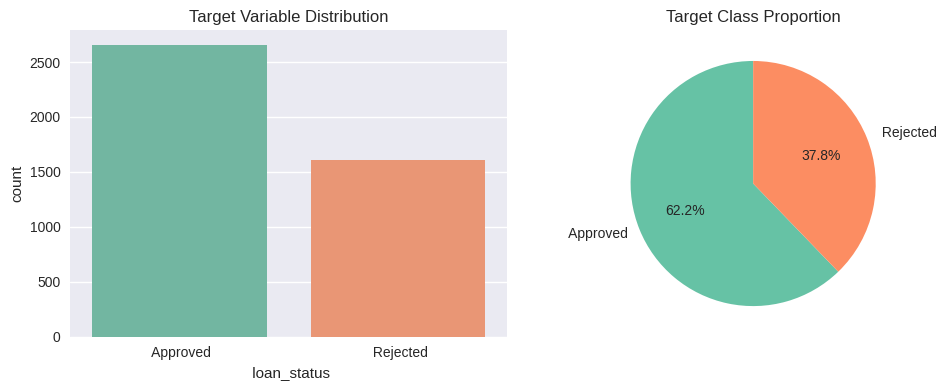

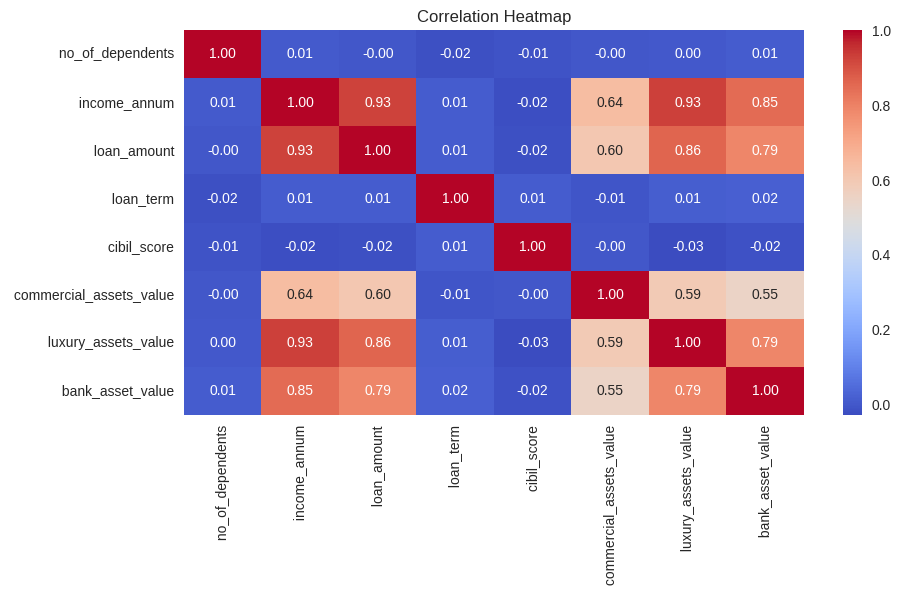

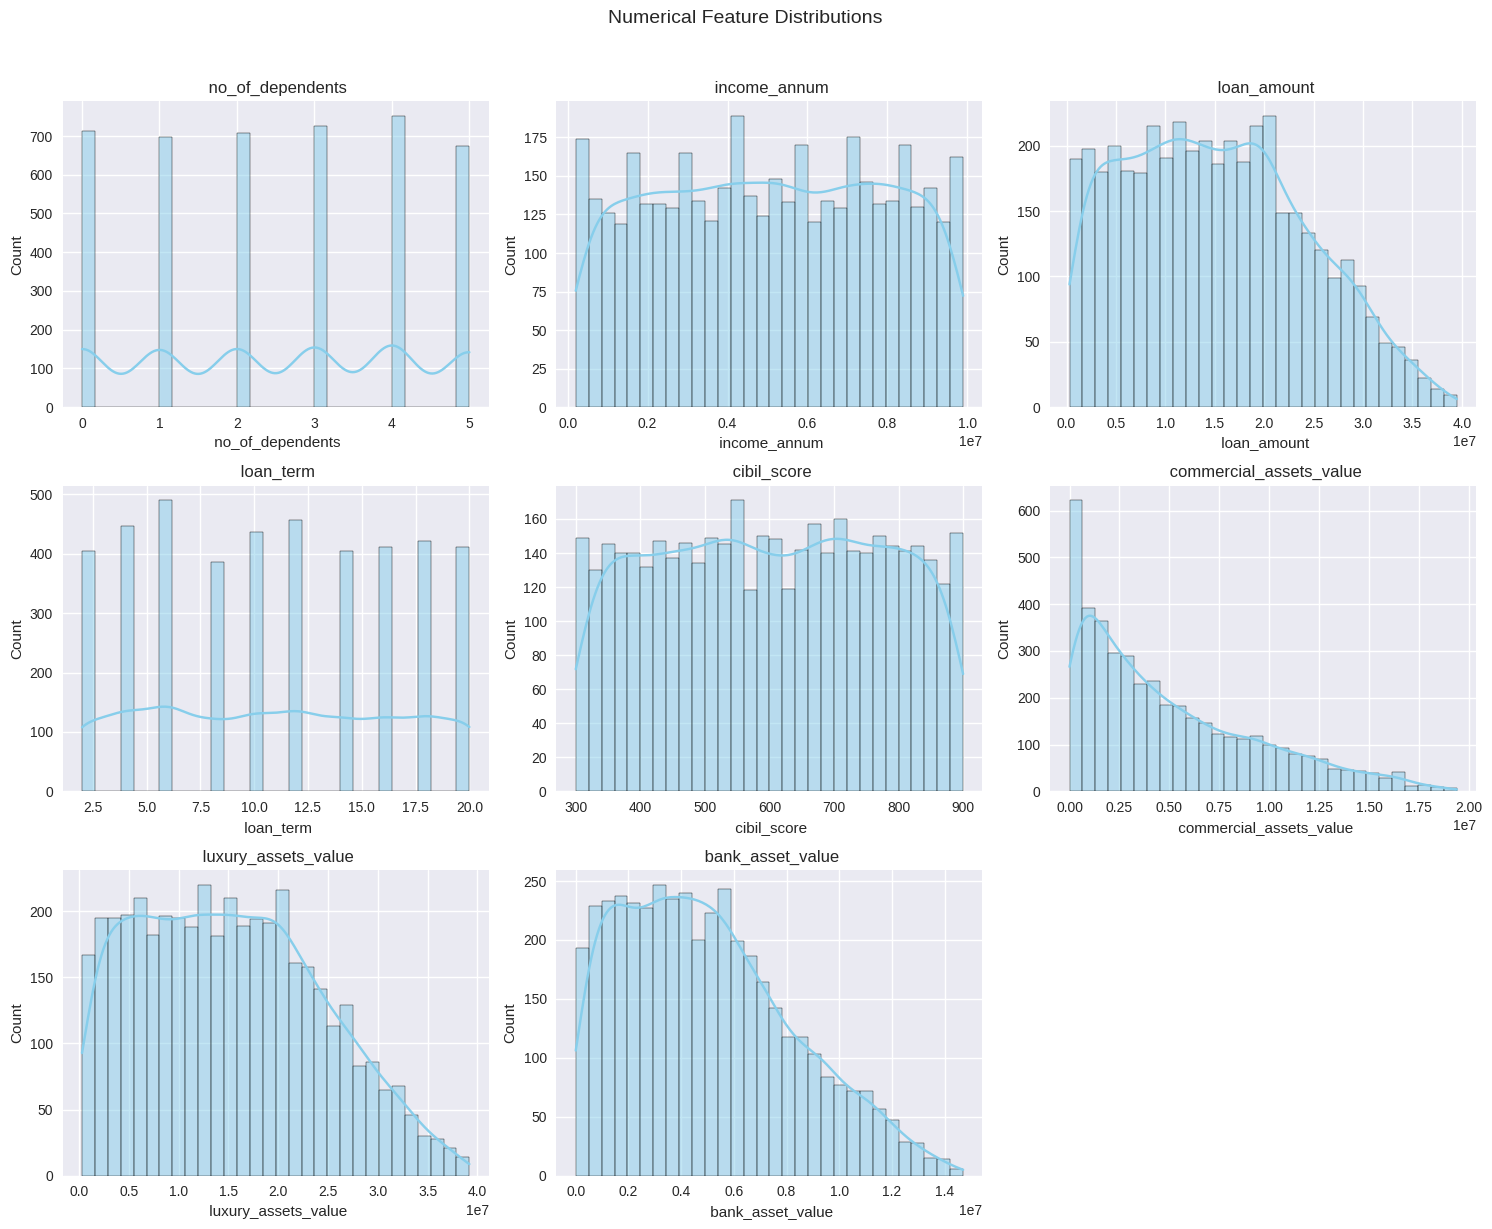

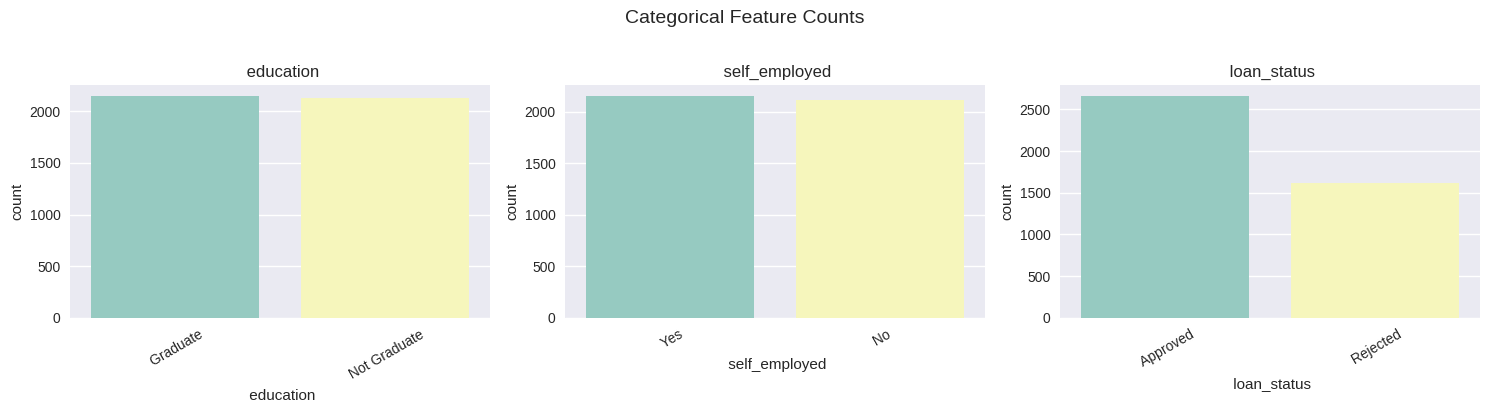


DATA PREPROCESSING
1) Handling missing values...
2) Encoding categorical variables...

Final dataset shape: (4269, 10) (features=10, samples=4269)

DATA SPLIT & SCALING
Train: 3415  |  Test: 854
• Features scaled with StandardScaler

MODEL TRAINING (with class-imbalance handling)
• Using SMOTE with k_neighbors=5.
✓ Trained: Logistic Regression
✓ Trained: Decision Tree
✓ Trained: Random Forest

📌 Logistic Regression
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       531
           1       0.91      0.91      0.91       323

    accuracy                           0.93       854
   macro avg       0.93      0.93      0.93       854
weighted avg       0.93      0.93      0.93       854

Confusion Matrix:
 [[501  30]
 [ 28 295]]

📌 Decision Tree
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       531
           1       0.98      0.97      0.97       323

    accuracy                  

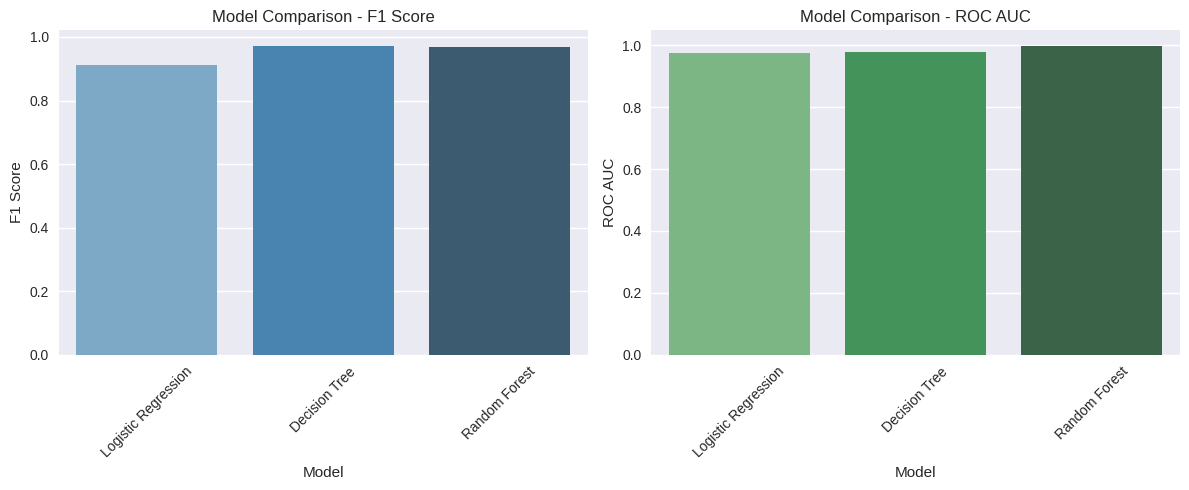


✅ ANALYSIS COMPLETED SUCCESSFULLY!


In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings('ignore')


class LoanApprovalPredictor:
    """
    Loan Approval Prediction System (Robust)
    - Auto-detects target column if not found
    - Handles missing values + encodes categoricals
    - Drops ID-like columns automatically
    - Class imbalance via SMOTE with adaptive k_neighbors
    - Clean metric handling for edge cases
    """

    def __init__(self, target_column='loan_status'):
        self.models = {}
        self.scaler = None
        self.encoders = {}
        self.feature_names = None
        self.target_column = target_column
        self.df = None
        self.results_df = None
        self.best_model = None
        self.best_model_name = None

    def perform_eda(self):
        """
        Exploratory Data Analysis (EDA) with aligned visualizations
        """
        print("\n" + "="*60)
        print("EXPLORATORY DATA ANALYSIS (EDA)")
        print("="*60)

        df = self.df.copy()

        # ---- Target Distribution ----
        if self.target_column in df.columns:
            fig, ax = plt.subplots(1, 2, figsize=(10, 4))
            sns.countplot(x=self.target_column, data=df, palette="Set2", ax=ax[0])
            ax[0].set_title("Target Variable Distribution")

            df[self.target_column].value_counts().plot.pie(
                autopct="%1.1f%%", startangle=90, ax=ax[1], colors=sns.color_palette("Set2")
            )
            ax[1].set_ylabel("")
            ax[1].set_title("Target Class Proportion")
            plt.tight_layout()
            plt.show()

        # ---- Correlation Heatmap ----
        num_cols = df.select_dtypes(include=[np.number]).columns
        if len(num_cols) > 1:
            plt.figure(figsize=(10, 5))
            corr = df[num_cols].corr()
            sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
            plt.title("Correlation Heatmap")
            plt.show()

        # ---- Numerical Feature Distributions ----
        if len(num_cols) > 0:
            n = len(num_cols)
            rows = (n + 2) // 3
            fig, axes = plt.subplots(rows, 3, figsize=(15, 4*rows))
            axes = axes.flatten()
            for i, col in enumerate(num_cols):
                sns.histplot(df[col].dropna(), kde=True, bins=30, color="skyblue", ax=axes[i])
                axes[i].set_title(f"{col}")
            for j in range(i+1, len(axes)):
                fig.delaxes(axes[j])
            plt.suptitle("Numerical Feature Distributions", fontsize=14, y=1.02)
            plt.tight_layout()
            plt.show()

        # ---- Categorical Feature Counts ----
        cat_cols = df.select_dtypes(include=['object', 'category']).columns
        if len(cat_cols) > 0:
            n = len(cat_cols)
            rows = (n + 2) // 3
            fig, axes = plt.subplots(rows, 3, figsize=(15, 4*rows))
            axes = axes.flatten()
            for i, col in enumerate(cat_cols):
                sns.countplot(x=col, data=df, palette="Set3", ax=axes[i],
                              order=df[col].value_counts().index[:10])  # top 10 if many categories
                axes[i].set_title(f"{col}")
                axes[i].tick_params(axis='x', rotation=30)
            for j in range(i+1, len(axes)):
                fig.delaxes(axes[j])
            plt.suptitle("Categorical Feature Counts", fontsize=14, y=1.02)
            plt.tight_layout()
            plt.show()

    # -------- helpers --------
    def _infer_target_column(self, df):
        candidates = [
            'loan_status', 'Loan_Status', 'LoanStatus',
            'status', 'Status', 'target', 'Target', 'y', 'label'
        ]
        # Case-insensitive lookup
        lower_map = {c.lower(): c for c in df.columns}
        for c in candidates:
            if c.lower() in lower_map:
                return lower_map[c.lower()]

        # As a last resort: pick a likely binary column
        for col in df.columns[::-1]:  # often target is last
            unique_vals = df[col].dropna().unique()
            if len(unique_vals) == 2:
                return col
        return None

    def _drop_id_like_columns(self, df):
        id_cols = [c for c in df.columns if 'id' in c.lower() or c.lower() in {'loan_id', 'app_id', 'customer_id'}]
        if id_cols:
            df = df.drop(columns=id_cols)
            print(f"• Dropped ID-like columns: {id_cols}")
        return df

    def _safe_auc(self, y_true, y_proba):
        # AUC defined only if both classes present
        if len(np.unique(y_true)) < 2:
            return None
        try:
            return float(roc_auc_score(y_true, y_proba))
        except Exception:
            return None

    def _adaptive_smote(self, y):
        # Choose k_neighbors based on minority count
        counts = Counter(y)
        if len(counts) < 2:
            return None, "Only one class present; skipping SMOTE."
        minority_count = min(counts.values())
        if minority_count <= 1:
            return None, "Minority count <= 1; skipping SMOTE."
        k = min(5, minority_count - 1)
        if k < 1:
            return None, "Not enough minority samples for SMOTE; skipping."
        return SMOTE(random_state=42, k_neighbors=k), f"Using SMOTE with k_neighbors={k}."

    # -------- main steps --------
    def load_and_explore_data(self, file_path=None, df=None):
        if df is not None:
            self.df = df.copy()
        elif file_path is not None:
            self.df = pd.read_csv(file_path)
        else:
            raise ValueError("Please provide either `file_path` or a pandas DataFrame `df`.")

        print("="*60)
        print("DATASET OVERVIEW")
        print("="*60)
        print(f"Dataset shape: {self.df.shape}")
        print(f"Samples: {self.df.shape[0]}")

        self.df = self._drop_id_like_columns(self.df)

        # Detect target if needed
        if self.target_column not in self.df.columns:
            inferred = self._infer_target_column(self.df)
            if inferred is None:
                raise ValueError(
                    "Target column not found. Please rename your target to 'loan_status' "
                    "or include a binary target column. Available columns:\n"
                    f"{list(self.df.columns)}"
                )
            else:
                print(f"• Target column inferred as: '{inferred}'")
                self.target_column = inferred

        print("\n" + "="*60)
        print("DATASET INFO")
        print("="*60)
        # Show info without printing 'None'
        self.df.info()

        print("\n" + "="*60)
        print("MISSING VALUES")
        print("="*60)
        missing = self.df.isnull().sum()
        missing_percent = (missing / len(self.df)) * 100
        miss_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percent}) \
                    .sort_values('Missing Count', ascending=False)
        print(miss_df[miss_df['Missing Count'] > 0])

        print("\n" + "="*60)
        print("TARGET VARIABLE DISTRIBUTION")
        print("="*60)
        if self.target_column in self.df.columns:
            tgt_counts = self.df[self.target_column].value_counts(dropna=False)
            tgt_pct = self.df[self.target_column].value_counts(normalize=True, dropna=False) * 100
            print("Counts:\n", tgt_counts)
            print("\nPercentages (%):\n", tgt_pct.round(2))
            if tgt_pct.min() < 40:
                print("\n⚠️  CLASS IMBALANCE DETECTED! SMOTE will be attempted.")

        return self.df

    def preprocess_data(self):
        print("\n" + "="*60)
        print("DATA PREPROCESSING")
        print("="*60)

        df = self.df.copy()

        # Convert boolean to int
        bool_cols = [c for c in df.columns if df[c].dtype == bool]
        for c in bool_cols:
            df[c] = df[c].astype(int)

        # Handle missing values
        print("1) Handling missing values...")
        num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != self.target_column]
        cat_cols = [c for c in df.select_dtypes(include=['object', 'category']).columns if c != self.target_column]

        for c in num_cols:
            if df[c].isnull().any():
                med = df[c].median()
                df[c] = df[c].fillna(med)

        for c in cat_cols:
            if df[c].isnull().any():
                mode = df[c].mode(dropna=True)
                fill = mode.iloc[0] if not mode.empty else "Unknown"
                df[c] = df[c].fillna(fill)

        # Encode categoricals
        print("2) Encoding categorical variables...")
        self.encoders = {}
        for c in cat_cols:
            le = LabelEncoder()
            df[c] = le.fit_transform(df[c].astype(str))
            self.encoders[c] = le

        # Encode target if needed
        if df[self.target_column].dtype in ['object', 'category']:
            le_tgt = LabelEncoder()
            df[self.target_column] = le_tgt.fit_transform(df[self.target_column].astype(str))
            self.encoders[self.target_column] = le_tgt

        X = df.drop(columns=[self.target_column])
        y = df[self.target_column].values
        self.feature_names = list(X.columns)

        print(f"\nFinal dataset shape: {X.shape} (features={X.shape[1]}, samples={X.shape[0]})")
        self.processed_df = df
        return X, y

    def split_and_scale_data(self, X, y, test_size=0.2, random_state=42):
        print("\n" + "="*60)
        print("DATA SPLIT & SCALING")
        print("="*60)

        stratify = y if len(np.unique(y)) > 1 else None
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=stratify
        )
        print(f"Train: {X_train.shape[0]}  |  Test: {X_test.shape[0]}")

        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_test_s = scaler.transform(X_test)
        self.scaler = scaler

        # 👇 Save them for evaluate_models
        self.X_train, self.X_test = X_train_s, X_test_s
        self.y_train, self.y_test = y_train, y_test

        print("• Features scaled with StandardScaler")
        return X_train_s, X_test_s, y_train, y_test


    def train_models(self, X_train, y_train):
        print("\n" + "="*60)
        print("MODEL TRAINING (with class-imbalance handling)")
        print("="*60)

        models = {
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
            'Decision Tree': DecisionTreeClassifier(random_state=42),
            'Random Forest': RandomForestClassifier(random_state=42, n_estimators=200)
        }

        smote_obj, smote_msg = self._adaptive_smote(y_train)
        if smote_obj is None:
            print(f"• SMOTE skipped: {smote_msg}")
            # Optional: use under-sampling to keep training going
            rus = RandomUnderSampler(random_state=42)
            sampler = ('undersample', rus)
        else:
            print(f"• {smote_msg}")
            sampler = ('smote', smote_obj)

        self.models = {}
        for name, clf in models.items():
            pipe = ImbPipeline([
                sampler,
                ('classifier', clf)
            ])
            pipe.fit(X_train, y_train)
            self.models[name] = pipe
            print(f"✓ Trained: {name}")
    def evaluate_models(self):
        results = []

        for name, model in self.models.items():
            model.fit(self.X_train, self.y_train)
            y_pred = model.predict(self.X_test)

            # probabilities for AUC
            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(self.X_test)[:, 1]
            else:
                y_prob = model.decision_function(self.X_test)
                y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())  # scale to [0,1]

            acc = accuracy_score(self.y_test, y_pred)
            prec = precision_score(self.y_test, y_pred)
            rec = recall_score(self.y_test, y_pred)
            f1 = f1_score(self.y_test, y_pred)
            auc = roc_auc_score(self.y_test, y_prob)

            results.append([name, acc, prec, rec, f1, auc])

            print(f"\n📌 {name}")
            print(classification_report(self.y_test, y_pred))
            print("Confusion Matrix:\n", confusion_matrix(self.y_test, y_pred))

        # Results DataFrame
        results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"])
        print("\n📊 Model Comparison:\n")
        print(results_df.to_string(index=False))

        # Best model selection (based on F1)
        best_idx = results_df["F1 Score"].idxmax()
        self.best_model_name = results_df.iloc[best_idx]["Model"]
        self.best_model = self.models[self.best_model_name]
        self.results_df = results_df

        print(f"\n🏆 BEST MODEL: {self.best_model_name} with F1 = {results_df.iloc[best_idx]['F1 Score']:.4f}")

        # ---------------- VISUALIZATIONS ----------------
        plt.figure(figsize=(12,5))

        # F1 Score Comparison
        plt.subplot(1,2,1)
        sns.barplot(x="Model", y="F1 Score", data=results_df, palette="Blues_d")
        plt.title("Model Comparison - F1 Score")
        plt.xticks(rotation=45)

        # AUC Comparison
        plt.subplot(1,2,2)
        sns.barplot(x="Model", y="ROC AUC", data=results_df, palette="Greens_d")
        plt.title("Model Comparison - ROC AUC")
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()
        # ------------------------------------------------

        return results_df
    def run_complete_analysis(self, file_path=None, df=None):
        print("🚀 STARTING LOAN APPROVAL PREDICTION ANALYSIS")
        print("="*80)
        try:
            self.load_and_explore_data(file_path=file_path, df=df)
            self.perform_eda()   # 👈 Added here
            X, y = self.preprocess_data()
            X_train, X_test, y_train, y_test = self.split_and_scale_data(X, y)
            self.train_models(X_train, y_train)
            results = self.evaluate_models()
            print("\n" + "="*80)
            print("✅ ANALYSIS COMPLETED SUCCESSFULLY!")
            print("="*80)
            return results
        except Exception as e:
            print("\n❌ ERROR:", str(e))
            print("Please verify your data format/columns and try again.")
            return None


# =============================
# USAGE
# =============================
if __name__ == "__main__":
    predictor = LoanApprovalPredictor()  # default target 'loan_status'; auto-detects if missing

    # Try common paths automatically (Colab and local sandbox)
    df = None
    tried = []
    for p in ["/content/loan_approval_dataset.csv", "/mnt/data/loan_approval_dataset.csv"]:
        try:
            df = pd.read_csv(p)
            print(f"• Loaded dataset from: {p}")
            break
        except Exception as _e:
            tried.append(p)

    if df is None:
        raise FileNotFoundError(
            "Could not load dataset from common paths.\n"
            "Tried:\n  - " + "\n  - ".join(tried) + "\n"
            "Please update the path below or pass df= directly."
        )

    results = predictor.run_complete_analysis(df=df)